# Boosting in Cox Regression

## Load libraries

In [1]:
# clear all workspace
rm(list=ls()) 
## load the required packages
library("mlr3")
library("mlr3proba")
library("mlr3learners")
library("mlr3extralearners")
library("data.table")
library("mlr3viz")
library("mlr3tuning")
library("mlr3pipelines")
library("purrr")
library("mboost")
library("CoxBoost")
library("survival")
library("paradox")
library("ggrepel")
library("precrec")
library("ggplot2")
library("ggpubr")
library("tidyverse")
library("mlr3filters")
library("ranger")


Attaching package: ‘mlr3extralearners’


The following object is masked from ‘package:mlr3learners’:

    LearnerClassifNnet


The following objects are masked from ‘package:mlr3’:

    lrn, lrns


Loading required package: paradox


Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Loading required package: parallel

Loading required package: stabs

Loading required package: survival

Loading required package: Matrix

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:mboost’:

    %+%


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()     masks mboost::%+%()
✖ dplyr::between()   masks data.table::between()
✖ tidyr::expand()    masks M

## Create the task for d3

In [2]:
# read in the raw data
train_data_original <- readRDS("~/Prediction_Challenge_T2E_ML/Data-20210107/train_data.Rds")

In [3]:
# get the corresponding dataframe
train_data_d3 <- train_data_original$d3

In [4]:
## create the corresponding task as for dataframe 1
tsks_train_d3 <- TaskSurv$new("df3", backend = train_data_original$d3, time = "time", event = "status")
## check the task
tsks_train_d3

<TaskSurv:df3> (617 x 10)
* Target: time, status
* Properties: -
* Features (8):
  - int (5): V2, V4, V6, V7, V8
  - fct (3): V1, V3, V5

## Hyperparameter Tuning for `d3`


#### Step 1: Boosting with the AFT model

Step 1_1: Try with a default setting

In [5]:
## load the learner for the aft boosting and design the benchmark
## Step 1_1: Try with a default setting
design <- benchmark_grid(
  tasks = tsks_train_d3,
  learners = lrn("surv.mboost", baselearner = "bols", family = "weibull"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
aft_bmr <- run_benchmark(design)

INFO  [19:29:43.049] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [19:29:43.216] [mlr3]  Applying learner 'surv.mboost' on task 'df3' (iter 2/3) 
INFO  [19:29:43.909] [mlr3]  Applying learner 'surv.mboost' on task 'df3' (iter 3/3) 
INFO  [19:29:44.496] [mlr3]  Applying learner 'surv.mboost' on task 'df3' (iter 1/3) 
INFO  [19:29:45.096] [mlr3]  Finished benchmark 


In [6]:
# set the global evaluation metric
all_measures <- msr("surv.cindex")

# evaluate the performance with the IBS score
aft_results <- aft_bmr$aggregate(measures = all_measures)
aft_results # 0.6733

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x55b65ba28000>,df3,surv.mboost,cv,3,0.673317


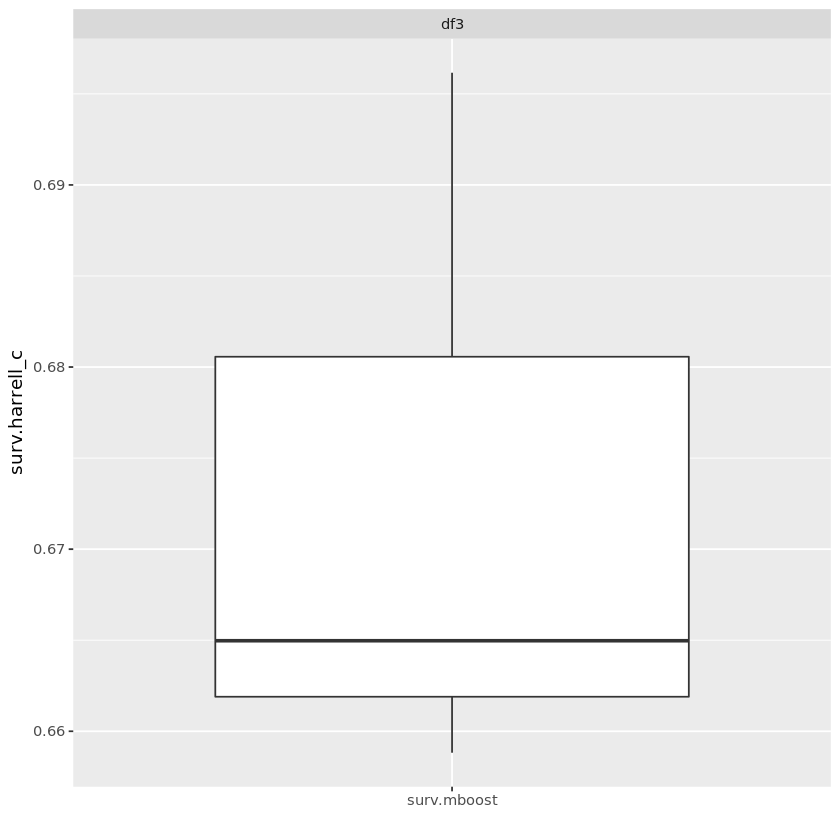

In [7]:
# plot the benchmark result with a default setting
autoplot(aft_bmr)

Step 1_2: Fine_tuning

In [14]:
# load the learner with aft
lrn_aft <- lrn("surv.mboost", baselearner = 'bols', family = "weibull")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("weibull", "loglog", "lognormal")

# set the search space
param_aft_bl <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 250),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 3L)

# create the AutoTuner
grid_auto_aft <- AutoTuner$new(
  learner = lrn_aft, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_aft_bl,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
aft_bmr_2 = resample(tsks_train_d3, grid_auto_aft, outer_rsmp, store_models = TRUE)

INFO  [19:35:15.004] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df3' (iter 1/3) 
INFO  [19:35:15.041] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [19:35:15.046] [bbotk] Evaluating 1 configuration(s) 
INFO  [19:35:15.075] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [19:35:15.085] [mlr3]  Applying learner 'surv.mboost' on task 'df3' (iter 1/3) 
INFO  [19:35:17.687] [mlr3]  Applying learner 'surv.mboost' on task 'df3' (iter 3/3) 
INFO  [19:35:20.300] [mlr3]  Applying learner 'surv.mboost' on task 'df3' (iter 2/3) 
INFO  [19:35:22.926] [mlr3]  Finished benchmark 
INFO  [19:35:22.976] [bbotk] Result of batch 1: 
INFO  [19:35:22.978] [bbotk]  baselearner  family mstop  nu surv.harrell_c 
INFO  [19:35:22.978] [bbotk]        btree weibull   150 0.5      0.6415406 
INFO  [19:35:22.978] [bbotk]                                 uhash 
INFO  [19:35:22.978] [bbotk]  b084416a-71cd-4a28-a4ad-9ade74c59b80 
INF

Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”
Warning message in optimize(riskS, interval = nuirange, y = y, fit = f, w = w):
“NA/Inf replaced by maximum positive value”


In [15]:
# evaluate the performance
aft_bmr_2$aggregate(measures = msr("surv.cindex")) # 0.671

surv.harrell_c 
     0.6710953

In [16]:
## optimal hyperparameters found by grid search
aft_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "loglog"

[[1]]$baselearner
[1] "btree"

[[1]]$mstop
[1] 200

[[1]]$nu
[1] 0.05

Step 1_3: Autoplot the pre and after tuning boxplots

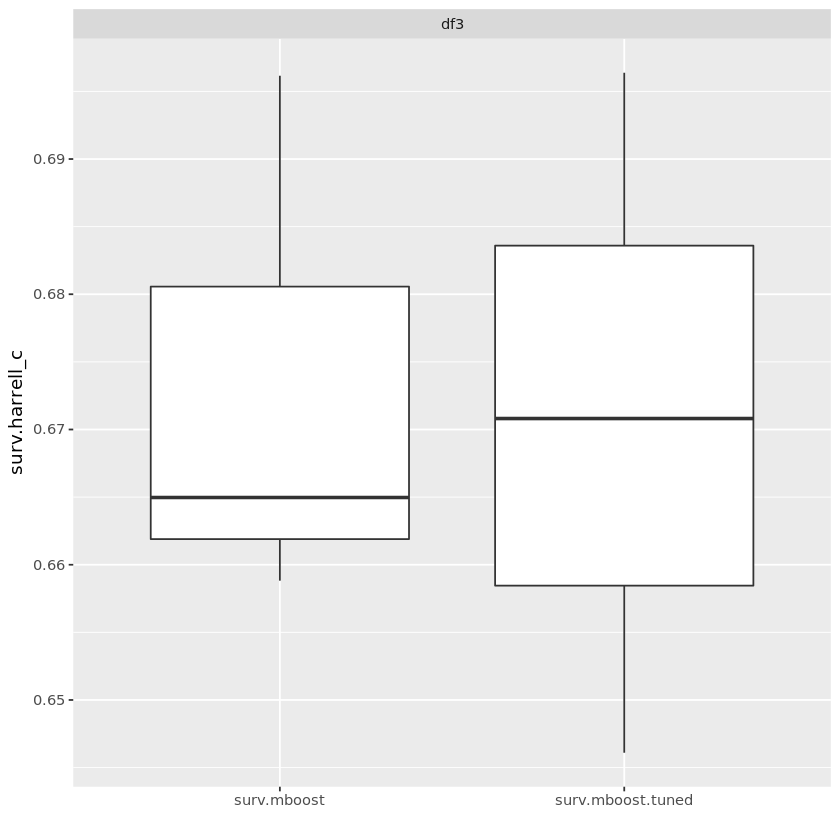

In [34]:
autoplot(c(aft_bmr, aft_bmr_2))

#### Step 2: mboost
Step 2_1: Try with a default setting

In [20]:
design <- benchmark_grid(
  tasks = tsks_train_d3,
  learners = lrn("surv.mboost", baselearner = 'bols', family = "coxph"), # cannot compute ‘bbs’ for non-numeric variables; used ‘bols’ instead.
  resampling = rsmp("cv", folds = 3L)
)


# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
mb_bmr <- run_benchmark(design)

INFO  [19:42:40.053] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [19:42:40.064] [mlr3]  Applying learner 'surv.mboost' on task 'df3' (iter 2/3) 
INFO  [19:42:44.077] [mlr3]  Applying learner 'surv.mboost' on task 'df3' (iter 3/3) 
INFO  [19:42:48.501] [mlr3]  Applying learner 'surv.mboost' on task 'df3' (iter 1/3) 
INFO  [19:42:52.530] [mlr3]  Finished benchmark 


In [21]:
mb_bmr_results <- mb_bmr$aggregate(msr("surv.cindex"))
mb_bmr_results # 0.670

nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x55b6605ca968>,df3,surv.mboost,cv,3,0.6697966


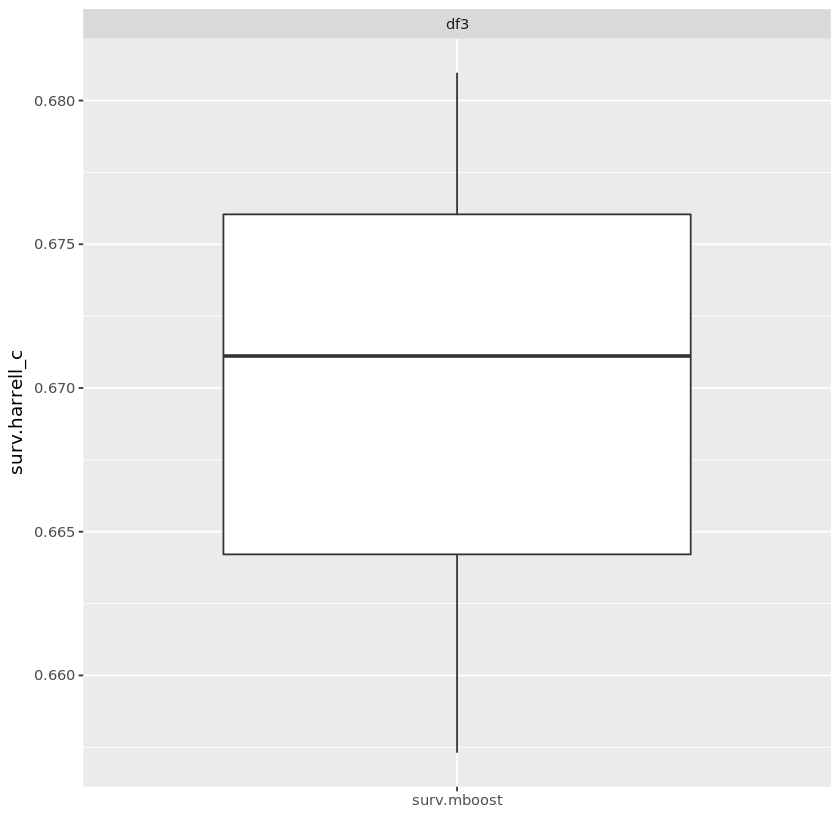

In [22]:
# plot the boxplots
autoplot(mb_bmr)

Step 2_2: Fine_tuning

In [23]:
# load the learner with mboost
lrn_mb <- lrn("surv.mboost", baselearner = 'bols', family = "coxph")
# train with "baselearner"
base_learner_type <- c("bols", "btree")
family_type <- c("cindex", "coxph")

# set the search space
param_mb <- ParamSet$new(params = list(
  ParamFct$new("baselearner", levels = base_learner_type),
  ParamFct$new("family", levels = family_type),
  ParamInt$new("mstop", lower = 50, upper = 250),
  ParamDbl$new("nu", lower = 0.05, upper = 0.5)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 3L)

# create the AutoTuner
grid_auto_mb <- AutoTuner$new(
  learner = lrn_mb, resampling = inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_mb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)
# design the benchmark with bf
# design_aft_bl <- benchmark_grid(
#   tasks = tsks_train_d1,
#   learners = aft_bl,
#   resamplings = outer_rsmp
# )
mb_bmr_2 = resample(tsks_train_d3, grid_auto_mb, outer_rsmp, store_models = TRUE)

INFO  [19:43:27.373] [mlr3]  Applying learner 'surv.mboost.tuned' on task 'df3' (iter 2/3) 
INFO  [19:43:27.413] [bbotk] Starting to optimize 4 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [19:43:27.418] [bbotk] Evaluating 1 configuration(s) 
INFO  [19:43:27.448] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [19:43:27.498] [mlr3]  Applying learner 'surv.mboost' on task 'df3' (iter 3/3) 
INFO  [19:43:30.908] [mlr3]  Applying learner 'surv.mboost' on task 'df3' (iter 2/3) 
INFO  [19:43:33.504] [mlr3]  Applying learner 'surv.mboost' on task 'df3' (iter 1/3) 
INFO  [19:43:36.039] [mlr3]  Finished benchmark 
INFO  [19:43:36.096] [bbotk] Result of batch 1: 
INFO  [19:43:36.098] [bbotk]  baselearner family mstop     nu surv.harrell_c 
INFO  [19:43:36.098] [bbotk]        btree  coxph    50 0.3875       0.685575 
INFO  [19:43:36.098] [bbotk]                                 uhash 
INFO  [19:43:36.098] [bbotk]  609d9e71-c3d8-4d45-8561-ef4d1fd0af5b 

In [24]:
# evaluate the performance
mb_bmr_2$aggregate() # 0.675

surv.harrell_c 
     0.6753601

In [25]:
## optimal hyperparameters found by grid search
mb_bmr_2$learners[[1]]$tuning_result$learner_param_vals

[[1]]
[[1]]$family
[1] "coxph"

[[1]]$baselearner
[1] "bols"

[[1]]$mstop
[1] 150

[[1]]$nu
[1] 0.5

Step 2_3: Autoplot the pre and after tuning boxplots

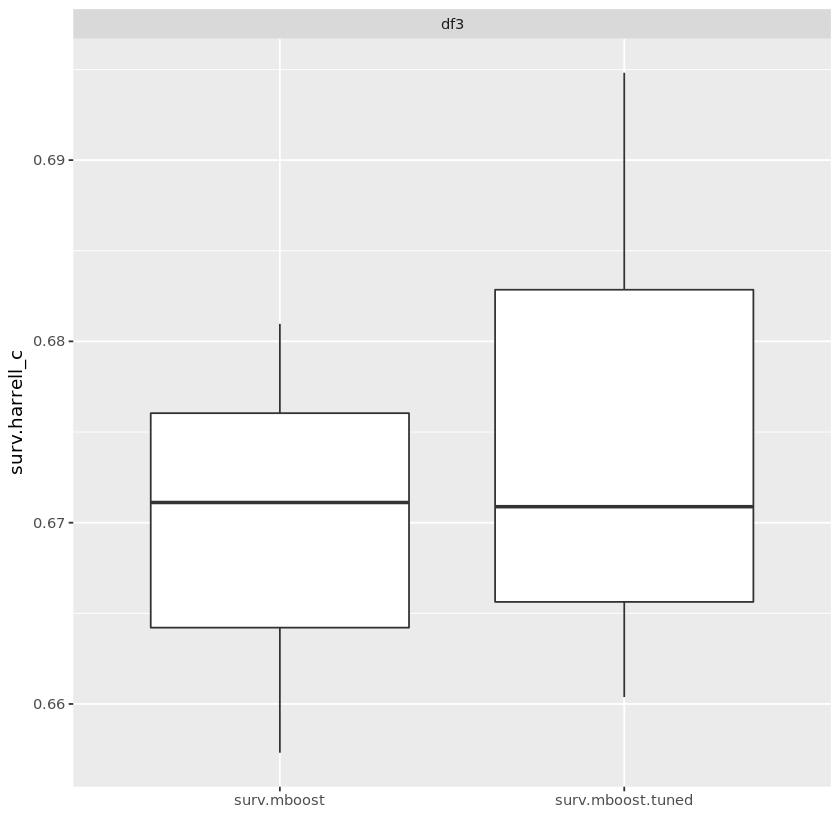

In [33]:
autoplot(c(mb_bmr, mb_bmr_2))

#### Step 3: CoxBoost
Step 3_1: Data Preprocessing to encode the nominal variables

In [35]:
# check the task
tsks_train_d3

<TaskSurv:df3> (617 x 10)
* Target: time, status
* Properties: -
* Features (8):
  - int (5): V2, V4, V6, V7, V8
  - fct (3): V1, V3, V5

In [36]:
library("dataPreparation")
# Compute encoding
train_onehot_d3 <- train_data_d3
encoding <- build_encoding(train_onehot_d3, cols = c("V1", "V3", "V5"), verbose = TRUE)
# Apply one hot encoding
train_onehot_d3 <- one_hot_encoder(train_onehot_d3, encoding = encoding, drop = TRUE)
str(train_onehot_d3)

## create the corresponding task as for dataframe 1 after one-hot-encoding
tsks_oh_d3 <- TaskSurv$new("df3", backend = train_onehot_d3, time = "time", event = "status")
tsks_oh_d3

Loading required package: lubridate


Attaching package: ‘lubridate’


The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: progress

dataPreparation 1.0.1

Type data_preparation_news() to see new features/changes/bug fixes.



[1] "build_encoding: I will compute encoding on 3 character and factor columns."
[1] "build_encoding: it took me: 0s to compute encoding for 3 character and factor columns."
[1] "one_hot_encoder: I will one hot encode some columns."
[1] "one_hot_encoder: I am doing column: V1"
[1] "one_hot_encoder: I am doing column: V3"
[1] "one_hot_encoder: I am doing column: V5"
[1] "one_hot_encoder: It took me 0s to transform 3 column(s)."
Classes ‘data.table’ and 'data.frame':	617 obs. of  14 variables:
 $ V2     : int  70 56 59 73 32 59 65 80 66 68 ...
 $ V4     : int  21 12 17 35 57 8 16 39 18 40 ...
 $ V6     : int  3 7 4 1 24 2 1 30 7 9 ...
 $ V7     : int  48 61 60 26 0 181 192 0 0 16 ...
 $ V8     : int  66 77 29 65 13 0 25 59 3 20 ...
 $ time   : int  1814 2018 1807 772 448 2172 2161 471 2014 577 ...
 $ status : int  1 1 1 1 1 0 0 1 0 1 ...
 $ V1.no  : int  1 0 0 1 1 0 1 1 1 0 ...
 $ V1.yes : int  0 1 1 0 0 1 0 0 0 1 ...
 $ V3.Post: int  1 1 1 1 0 1 1 1 1 1 ...
 $ V3.Pre : int  0 0 0 0 1 0 

<TaskSurv:df3> (617 x 14)
* Target: time, status
* Properties: -
* Features (12):
  - int (12): V1.no, V1.yes, V2, V3.Post, V3.Pre, V4, V5.I, V5.II,
    V5.III, V6, V7, V8

Step 3_2: Try with a default setting

In [37]:
library("pracma")


Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu


The following object is masked from ‘package:purrr’:

    cross




In [38]:
install_learners('surv.coxboost')

In [39]:
design <- benchmark_grid(
  tasks = tsks_oh_d3,
  learners = lrn("surv.coxboost", criterion="hpscore"),
  resampling = rsmp("cv", folds = 3L)
)

# lrn("surv.coxboost")$param_set

# define function to start benchmark with fixed seed
run_benchmark <- function(design){
  set.seed(2021)
  bmr <- benchmark(design, store_models = TRUE)
  run_benchmark <- bmr
}

## run benchmark and save the results
coxboost_bmr <- run_benchmark(design)


# set the global evaluation metric
all_measures <- msr("surv.cindex")

coxboost_results <- coxboost_bmr$aggregate(measures = all_measures)
coxboost_results # 0.673

INFO  [20:09:35.190] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [20:09:35.204] [mlr3]  Applying learner 'surv.coxboost' on task 'df3' (iter 2/3) 
INFO  [20:09:42.014] [mlr3]  Applying learner 'surv.coxboost' on task 'df3' (iter 3/3) 
INFO  [20:09:48.804] [mlr3]  Applying learner 'surv.coxboost' on task 'df3' (iter 1/3) 
INFO  [20:09:56.642] [mlr3]  Finished benchmark 


nr,resample_result,task_id,learner_id,resampling_id,iters,surv.harrell_c
<int>,<list>,<chr>,<chr>,<chr>,<int>,<dbl>
1,<environment: 0x55b6a9c02b68>,df3,surv.coxboost,cv,3,0.6728556


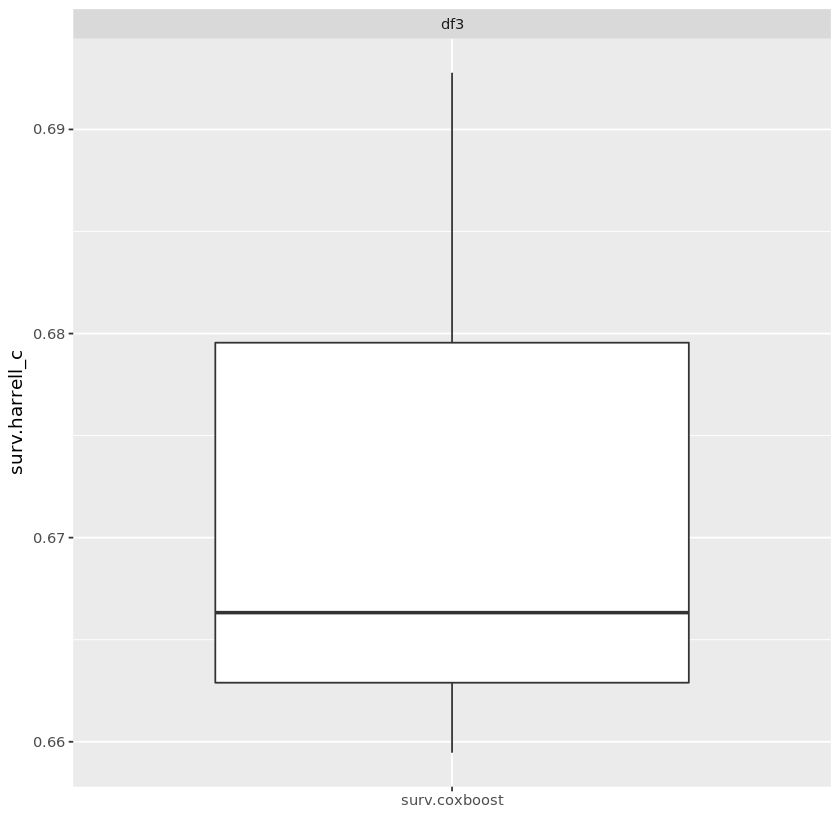

In [41]:
# plot the corresponding the performance
autoplot(coxboost_bmr)

Step_3_3: Fine-tuning with CoxBoost

In [42]:
# load the learner with CoxBoost
lrn_cb <- lrn("surv.coxboost", criterion="hpscore")
# from 50-250, 100-300, 150-250

# set the search space
param_cb <- ParamSet$new(params = list(
  ParamInt$new("stepno", lower = 50, upper = 250),
  ParamDbl$new("penalty", lower = 100, upper = 500),
  ParamDbl$new("stepsize.factor", lower = 0.1, upper = 10)
))

# inner resampling set
inner_rsmp <- rsmp("cv", folds = 3L)

# create the AutoTuner
grid_auto_cb <- AutoTuner$new(
  learner = lrn_cb, resampling =  inner_rsmp,
  measure = msr("surv.cindex"), search_space = param_cb,
  terminator = trm("evals", n_evals = 20), tuner = tnr("grid_search", resolution = 5)
)
# set the outer resampling
outer_rsmp <- rsmp("cv", folds = 3L)

cb_bmr_2 = resample(tsks_oh_d3, grid_auto_cb, outer_rsmp, store_models = TRUE)

INFO  [20:11:25.652] [mlr3]  Applying learner 'surv.coxboost.tuned' on task 'df3' (iter 2/3) 
INFO  [20:11:25.684] [bbotk] Starting to optimize 3 parameter(s) with '<OptimizerGridSearch>' and '<TerminatorEvals> [n_evals=20]' 
INFO  [20:11:25.689] [bbotk] Evaluating 1 configuration(s) 
INFO  [20:11:25.753] [mlr3]  Benchmark with 3 resampling iterations 
INFO  [20:11:25.762] [mlr3]  Applying learner 'surv.coxboost' on task 'df3' (iter 1/3) 
INFO  [20:11:29.758] [mlr3]  Applying learner 'surv.coxboost' on task 'df3' (iter 3/3) 
INFO  [20:11:33.895] [mlr3]  Applying learner 'surv.coxboost' on task 'df3' (iter 2/3) 
INFO  [20:11:38.745] [mlr3]  Finished benchmark 
INFO  [20:11:38.793] [bbotk] Result of batch 1: 
INFO  [20:11:38.796] [bbotk]  stepno penalty stepsize.factor surv.harrell_c 
INFO  [20:11:38.796] [bbotk]     200     200            5.05      0.6788322 
INFO  [20:11:38.796] [bbotk]                                 uhash 
INFO  [20:11:38.796] [bbotk]  cc7ebe5d-a000-41a6-9524-53b321e

In [43]:
# evaluate the performance
cb_bmr_2$aggregate() # 0.669

surv.harrell_c 
     0.6694352

In [44]:
## optimal hyperparameters found by grid search
cb_bmr_2$learners[[1]]$tuning_result$learner_param_vals	

[[1]]
[[1]]$criterion
[1] "hpscore"

[[1]]$stepno
[1] 50

[[1]]$penalty
[1] 500

[[1]]$stepsize.factor
[1] 5.05

Step_3_4: Autoplot the pre and after tuning boxplots

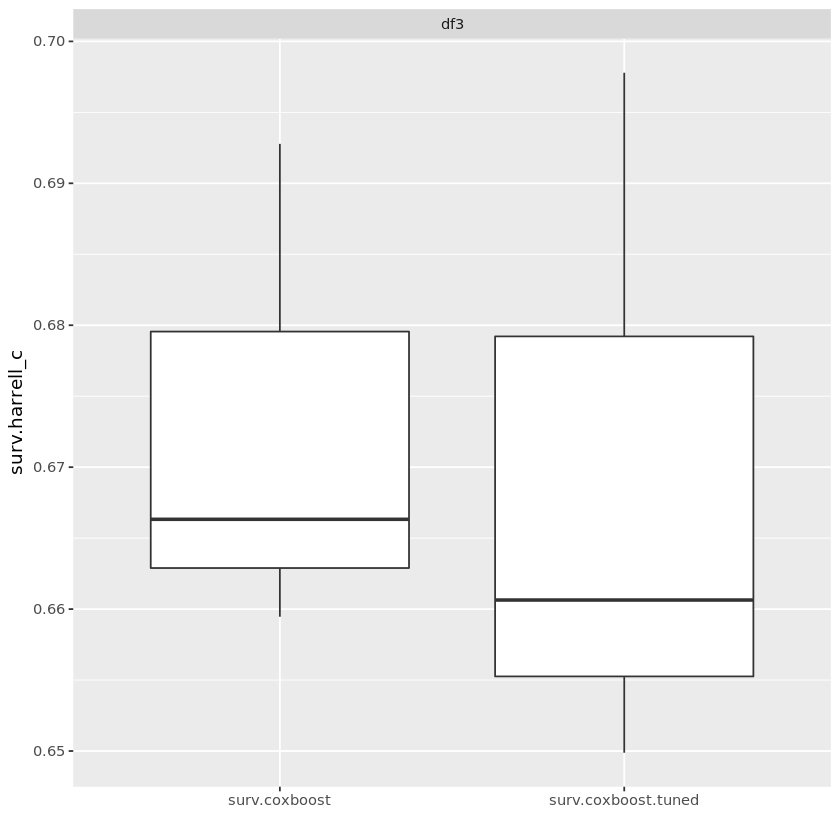

In [46]:
# autoplot the two boxplots
autoplot(c(coxboost_bmr, cb_bmr_2))